# DyND Callable MultiDispatch in Python

This is a notebook which goes with the [DyND Callable Multi-Dispatch Design](callable-multidispatch-design.md).
It's an implementation of the described signature subset construction, with the aim to illustrate the algorithm
clearly. We will build up an implementation in stages, starting with simple cases and gradually escalating the
complexity to account for more of the pattern matching capabilities that DyND types have.

In [1]:
import dynd
from dynd import nd, ndt
from pprint import pprint
print("libdynd", dynd.__libdynd_version__, ", dynd-python", dynd.__version__)

libdynd v0.7.2-975-ga53df83 , dynd-python v0.7.2-278-gbbf2ace


In [2]:
import functools
class reprwrapper(object):
    def __init__(self, reprstr, func):
        self._reprstr = reprstr
        self._func = func
        functools.update_wrapper(self, func)
    def __call__(self, *args, **kw):
        return self._func(*args, **kw)
    def __repr__(self):
        return self._reprstr

def withrepr(reprstr):
    def _wrap(func):
        return reprwrapper(reprstr, func)
    return _wrap

## Simple Scalar Signatures

Let's start with a few scalar signatures.

In [3]:
sigs = [ndt.type("(int8, int8) -> int8"),
        ndt.type("(int16, int16) -> int16"),
        ndt.type("(float32, float32) -> float32")]

In [4]:
sigs_working = [s.pos_types for s in sigs]; pprint(sigs_working)

[[ndt.type('int8'), ndt.type('int8')],
 [ndt.type('int16'), ndt.type('int16')],
 [ndt.type('float32'), ndt.type('float32')]]


For this initial case, we don't need to track additional working state, so that's it. We do need
a set of equations that need to be satisfied for a match. The only form of equation at this point is
`S.TInp[i].matches(TInp[i])`, so we'll just store the `i`.

In [5]:
equations = [0, 1]

Each node of the decision tree will process an equation, either completely or partially by decomposing
it into additional simpler equations. We're starting really simple, so that we can build up the complexity of
the final algorithm incrementally.

In [6]:
def child_edges(sigs_working, i):
    return {sig[i].id for sig in sigs_working if sig is not None}

def filter_sigs(sigs_working, i, tid):
    return [sig if sig and sig[i].id == tid else None for sig in sigs_working]

We're going to just process the first equation at each step. Eventually, we'll want to pick the
equation which maximizes how quickly we shrink the set of working signatures, but we'll not do that yet.

In [7]:
edges = {tid: filter_sigs(sigs_working, equations[0], tid)
         for tid in child_edges(sigs_working, equations[0])}
pprint(edges)

{6: [[ndt.type('int8'), ndt.type('int8')], None, None],
 7: [None, [ndt.type('int16'), ndt.type('int16')], None],
 19: [None, None, [ndt.type('float32'), ndt.type('float32')]]}


This gave us a decision tree node which looks at the type id of argument zero. We now need to recursively apply
what we just did to every outgoing edge of of the node to complete the tree.

In [8]:
def build_decision_tree_node(sigs_working, equations):
    if equations:
        # For now, always processing the first equation
        i, equations = equations[0], equations[1:]
        # Each equation generates a candidate decision tree node
        edges = {tid: filter_sigs(sigs_working, i, tid)
                 for tid in child_edges(sigs_working, i)}
        # Build the child nodes recursively
        return ('typeid', i, {tid: build_decision_tree_node(edges[tid], equations)
                              for tid in edges})
    else:
        # When there are no equations left, the arguments are fully matched
        results = [i for (i, sig) in enumerate(sigs_working) if sig is not None]
        if len(results) == 1:
            return ('match', results[0])
        elif(results):
            return ('ambiguous', results)
        else:
            return ('nomatch')
        

def build_decision_tree(sigs):
    sigs_working = [s.pos_types for s in sigs]
    equations = list(range(len(sigs_working[0])))
    return build_decision_tree_node(sigs_working, equations)

In [9]:
pprint(build_decision_tree(sigs))

('typeid',
 0,
 {6: ('typeid', 1, {6: ('match', 0)}),
  7: ('typeid', 1, {7: ('match', 1)}),
  19: ('typeid', 1, {19: ('match', 2)})})


The final thing we want to do is convert the decision tree into some bytecode that can be executed quickly.
We'll model the bytecode as a list of functions that modify a simple machine state.

In [10]:
class MachineResult(Exception):
    def __init__(self, result):
        self.result = result

class MachineState:
    def __init__(self, tinp):
        self.tinp = tinp
    def run(self, instr):
        try:
            i = 0;
            while True:
                i = instr[i](self)
        except MachineResult as e:
            return e.result

def build_machine(decision_tree, instr=None):
    if instr is None:
        instr = []
        build_machine(decision_tree, instr)
        return instr
    i = len(instr)
    if(decision_tree[0] == 'match'):
        @withrepr('L%d <return match %d>' % (i, decision_tree[1]))
        def _match(state):
            raise MachineResult(decision_tree[1])
        instr.append(_match)
    elif(decision_tree[0] == 'ambiguous'):
        @withrepr('L%d <raise ambiguous %r>' % (i, decision_tree[1]))
        def _ambiguous(state):
            raise Exception('Ambiguous matches %s' % decision_tree[1])
        instr.append(_ambiguous)
    elif(decision_tree[0] == 'nomatch'):
        @withrepr('L%d <raise nomatch>' % (i,))
        def _nomatch(state):
            raise Exception('No match found')
        instr.append(_nomatch)
    elif(decision_tree[0] == 'typeid'):
        instr.append(None)
        nextinstr = {tid: build_machine(decision_tree[2][tid], instr)
                     for tid in sorted(decision_tree[2])}
        @withrepr('L%d <switch typeid[%d] goto {%s}>' %
                  (i, decision_tree[1], ', '.join('%d: L%d' % (k, nextinstr[k]) for k in sorted(nextinstr))))
        def _typeid(state):
            tid = state.tinp[decision_tree[1]].id
            if not tid in nextinstr:
                raise Exception('No match found')
            else:
                return nextinstr[tid]
        instr[i] = _typeid
    return i

In [11]:
instr = build_machine(build_decision_tree(sigs)); pprint(instr)

[L0 <switch typeid[0] goto {6: L1, 7: L3, 19: L5}>,
 L1 <switch typeid[1] goto {6: L2}>,
 L2 <return match 0>,
 L3 <switch typeid[1] goto {7: L4}>,
 L4 <return match 1>,
 L5 <switch typeid[1] goto {19: L6}>,
 L6 <return match 2>]


Now we can run run these instructions on a few different matching and non-matching argument types.

In [12]:
MachineState([ndt.int8, ndt.int8]).run(instr)

0

In [13]:
MachineState([ndt.float32, ndt.float32]).run(instr)

2

In [14]:
MachineState([ndt.int32, ndt.int32]).run(instr)

Exception: No match found

What we've created already works pretty well for simple scalar signatures, let's give the one we used a slight twist.

In [15]:
sigs2 = [ndt.type("(int8, int8) -> int8"),
         ndt.type("(int16, int16) -> int16"),
         ndt.type("(float32, float32) -> float32"),
         ndt.type("(int16, float32) -> float32")]
instr = build_machine(build_decision_tree(sigs2)); pprint(instr)

[L0 <switch typeid[0] goto {6: L1, 7: L3, 19: L6}>,
 L1 <switch typeid[1] goto {6: L2}>,
 L2 <return match 0>,
 L3 <switch typeid[1] goto {7: L4, 19: L5}>,
 L4 <return match 1>,
 L5 <return match 3>,
 L6 <switch typeid[1] goto {19: L7}>,
 L7 <return match 2>]


This results in a slightly modified decision tree and machine, that has a branch at the second level if the
first argument was `int16`.

## Signatures With Type Variables

While it's maybe nice to hone in on specific signatures quickly with the described machine, DyND
callable signatures include more complicated matching abilities via type variables, dimensions,
and other types with type parameters. We're going to start with just adding two signatures
including type variables, which will require some type substitution and eliminating signatures via
the `matches` partial ordering.

The machine we've built to execute matching began with just the state `tinp`, consisting of the
argument input types. We're going to change our `sigs_working` data from just consisting of a list
of the signature argument types that correspond to `tinp` into a list of objects modeling the machine
state. Both our machine state and the symbolic model of it will gain a new `twork` list, which
is where types, typically components of an equation being processed, are placed to generate new
equations.

In [16]:
sigs3 = [ndt.type("(int8, int8) -> int8"),
         ndt.type("(int16, int16) -> int16"),
         ndt.type("(float32, float32) -> float32"),
         ndt.type("(int16, float32) -> float32"),
         ndt.type("(T, T) -> T"),
         ndt.type("(S, T) -> T")]

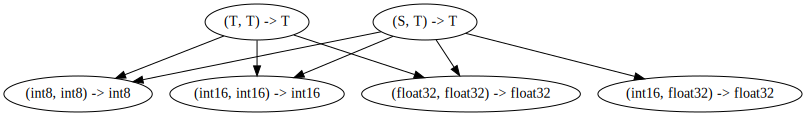

In [21]:
# NOTE: http://stackoverflow.com/questions/33433274/anaconda-graphviz-cant-import-after-installation
#       To install graphviz, you need both of the following:
# > conda install graphviz
# > pip install graphviz
import graphviz
def plot_matches_graph(sigs):
    dot = graphviz.Digraph()
    for i, node in enumerate(sigs):
        dot.node(str(i), str(node))
    for i, inode in enumerate(sigs):
        for j, jnode in enumerate(sigs[i+1:], start=i+1):
            if inode.match(jnode):
                dot.edge(str(i), str(j))
            elif jnode.match(inode):
                dot.edge(str(j), str(i))
    return dot

plot_matches_graph(sigs3)